In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rlefile/stage_2_train.csv
/kaggle/input/rlefiles/train-rle.csv


In [2]:
import os
import cv2
import glob2
import pydicom
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import exposure
import sys

In [3]:
sz = 512
sz0 = 1024
mask_out = 'masks.zip'
df = pd.read_csv('../input/rlefile/stage_2_train.csv').set_index('ImageId')

In [4]:
idxs = set(df.index)

In [5]:
df.shape

(12954, 2)

In [6]:
def rle2mask(rle, width = 512, height = 512):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 1
        current_position += lengths[index]

    return mask.reshape(width, height)

In [7]:
mask_coverage = []
mask_count = 0
mask_count_tot = 0
with zipfile.ZipFile(mask_out, 'w') as arch:
    for idx in tqdm(idxs):
        masks = df.loc[idx,'EncodedPixels']
        img = np.zeros((sz0,sz0))
        #do conversion if mask is not " -1"
        if(type(masks) != str or (type(masks) == str and masks != '-1')):
            if(type(masks) == str): masks = [masks]
            else: masks = masks.tolist()
            mask_count +=1
            for mask in masks:
                mask_count_tot += 1
                img += rle2mask(mask, sz0, sz0).T
        mask_coverage.append(img.mean())
        img = cv2.resize(img, (sz, sz))
        output = cv2.imencode('.png',img)[1]
        name = idx + '.png'
        arch.writestr(name, output)

print('mask coverage:', np.mean(mask_coverage)/255, ', mask count:', mask_count,
      ', mask count tot:', mask_count_tot)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



mask coverage: 1.2333862171470468e-05 , mask count: 2669 , mask count tot: 3576


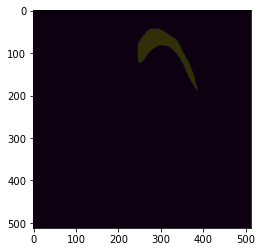

In [8]:
idx = 736
with zipfile.ZipFile(mask_out, 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    mask = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)
    
plt.figure()
plt.imshow(Image.fromarray(img))
plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()